# GradCAM - Gradient Class Activation Map

In [1]:
!git clone https://github.com/Harith-Y/GradCAM-Project.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

fatal: destination path 'GradCAM-Project' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ual5jb7t
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ual5jb7t
  Resolved https://github.com/albumentations-team/albumentations to commit 72d97269c9bee2d1a447bf86c4bbe5010c238f33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Project')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm

import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_Data = "/content/GradCAM-Project/train.csv"
DATA_DIR = "/content/GradCAM-Project/"

DEVICE = 'cuda'

batch_size = 16
lr = 0.001
epochs = 20

In [5]:
data = pd.read_csv(CSV_Data)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
# Cucumber - 0
# Eggplant - 1
# Mushroom - 2

train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
  ])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [8]:
trainset = utils.ImageDataset(train_df, data_dir = DATA_DIR, augs = train_augs)
validset = utils.ImageDataset(valid_df, data_dir = DATA_DIR, augs = valid_augs)

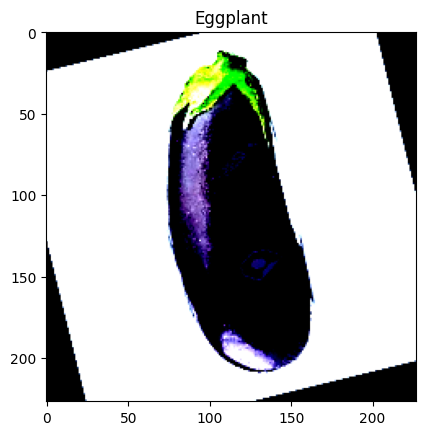

In [9]:
image, label = trainset[0]

class_list = ['Cucumber', 'Eggplant', 'Mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [10]:
print(f"No. of examples in the trainset: {len(trainset)}")
print(f"No. of examples in the validset: {len(validset)}")

No. of examples in the trainset: 148
No. of examples in the validset: 38


# Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size, shuffle = False)

In [12]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [13]:
for image, labels in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

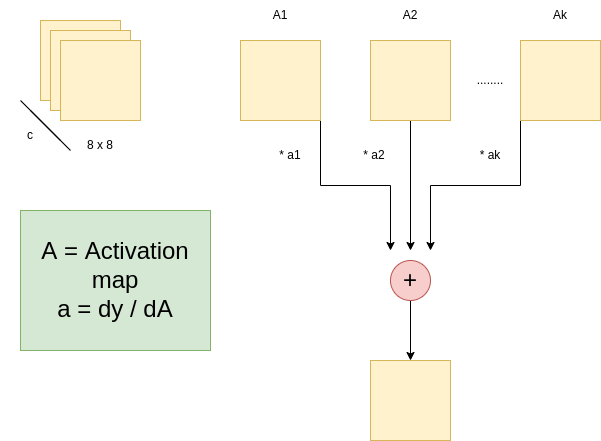

In [14]:
class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential (
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride = 2),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride = 2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride = 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
        nn.ReLU(),
    )

    self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400,2048),
        nn.ReLU(),
        nn.Linear(2048,3),
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images) # Use as a activation maps

    h = x.register_hook(self.activations_hook)

    x = self.maxpool(x)
    x = self.classifier(x)

    return x


  def get_activations_gradient(self): # a1, a2, ..., ak
    return self.gradient

  def get_activations(self, x): # A1, A2, ..., Ak
    return self.feature_extractor(x)


In [15]:
 model = ImageModel()
 model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [16]:
def train_fn(DataLoader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(DataLoader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(DataLoader)

In [17]:
def eval_fn(DataLoader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(DataLoader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)

    total_loss += loss.item()
  return total_loss / len(DataLoader)

# Training Loop

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
best_value_loss = np.inf

for epoch in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_value_loss:
    best_value_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print("SAVED WEIGHTS SUCCESS")

  print(f"EPOCH: {epoch + 1} \t TRAIN LOSS: {train_loss} \t VALID LOSS: {valid_loss}")

100%|██████████| 3/3 [00:00<00:00, 39.81it/s]


SAVED WEIGHTS SUCCESS
EPOCH: 1 	 TRAIN LOSS: 1.1661815524101258 	 VALID LOSS: 1.0060917536417644


100%|██████████| 3/3 [00:00<00:00, 34.97it/s]


SAVED WEIGHTS SUCCESS
EPOCH: 2 	 TRAIN LOSS: 0.9122372448444367 	 VALID LOSS: 0.8271989425023397


100%|██████████| 3/3 [00:00<00:00, 40.21it/s]


EPOCH: 3 	 TRAIN LOSS: 0.7198474846780301 	 VALID LOSS: 1.0384495854377747


100%|██████████| 3/3 [00:00<00:00, 39.46it/s]


SAVED WEIGHTS SUCCESS
EPOCH: 4 	 TRAIN LOSS: 0.6766839623451233 	 VALID LOSS: 0.6547022064526876


100%|██████████| 3/3 [00:00<00:00, 37.46it/s]


SAVED WEIGHTS SUCCESS
EPOCH: 5 	 TRAIN LOSS: 0.46460357143078 	 VALID LOSS: 0.23940331488847733


100%|██████████| 3/3 [00:00<00:00, 37.95it/s]


EPOCH: 6 	 TRAIN LOSS: 0.2002215306391008 	 VALID LOSS: 1.1692469120025635


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]


EPOCH: 7 	 TRAIN LOSS: 0.25508260882925243 	 VALID LOSS: 0.45409877846638363


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]


EPOCH: 8 	 TRAIN LOSS: 0.341604495793581 	 VALID LOSS: 0.4110548297564189


100%|██████████| 3/3 [00:00<00:00, 26.41it/s]


SAVED WEIGHTS SUCCESS
EPOCH: 9 	 TRAIN LOSS: 0.10208140667527914 	 VALID LOSS: 0.23096198588609695


100%|██████████| 3/3 [00:00<00:00, 29.93it/s]


EPOCH: 10 	 TRAIN LOSS: 0.07042655609548092 	 VALID LOSS: 0.31921464794625837


100%|██████████| 3/3 [00:00<00:00, 39.06it/s]


SAVED WEIGHTS SUCCESS
EPOCH: 11 	 TRAIN LOSS: 0.024020352761726826 	 VALID LOSS: 0.15401394983928185


100%|██████████| 3/3 [00:00<00:00, 40.90it/s]


EPOCH: 12 	 TRAIN LOSS: 0.08343097617980674 	 VALID LOSS: 0.48340907754997414


100%|██████████| 3/3 [00:00<00:00, 38.85it/s]


EPOCH: 13 	 TRAIN LOSS: 0.43330022966256365 	 VALID LOSS: 0.2760575811068217


100%|██████████| 3/3 [00:00<00:00, 43.74it/s]


EPOCH: 14 	 TRAIN LOSS: 0.2624482035636902 	 VALID LOSS: 0.3565528194109599


100%|██████████| 3/3 [00:00<00:00, 38.22it/s]


EPOCH: 15 	 TRAIN LOSS: 0.11471766037866474 	 VALID LOSS: 0.35194607141117257


100%|██████████| 3/3 [00:00<00:00, 40.52it/s]


EPOCH: 16 	 TRAIN LOSS: 0.08763855495490133 	 VALID LOSS: 0.2699524772663911


100%|██████████| 3/3 [00:00<00:00, 40.01it/s]


SAVED WEIGHTS SUCCESS
EPOCH: 17 	 TRAIN LOSS: 0.035284544248133896 	 VALID LOSS: 0.12995790127509585


100%|██████████| 3/3 [00:00<00:00, 38.76it/s]


EPOCH: 18 	 TRAIN LOSS: 0.03237518169917166 	 VALID LOSS: 0.31950473381827277


100%|██████████| 3/3 [00:00<00:00, 43.21it/s]


EPOCH: 19 	 TRAIN LOSS: 0.06451013096375391 	 VALID LOSS: 0.23618443711893633


100%|██████████| 3/3 [00:00<00:00, 43.77it/s]

EPOCH: 20 	 TRAIN LOSS: 0.3204770921423915 	 VALID LOSS: 0.9377681088323394


# Get GradCAM

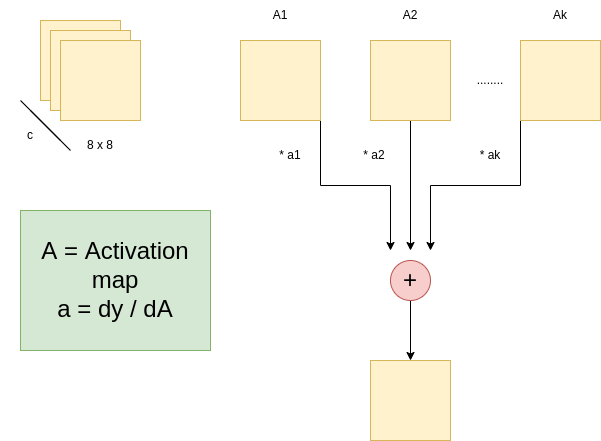

In [20]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = model.get_activations(image).detach() # A1, A2, ..., Ak

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)

  # heatmap = np.maximum(heatmap, 0)
  heatmap /= torch.max(heatmap)
  heatmap = heatmap.numpy()

  img = cv2.resize(heatmap, (size, size))

  return heatmap

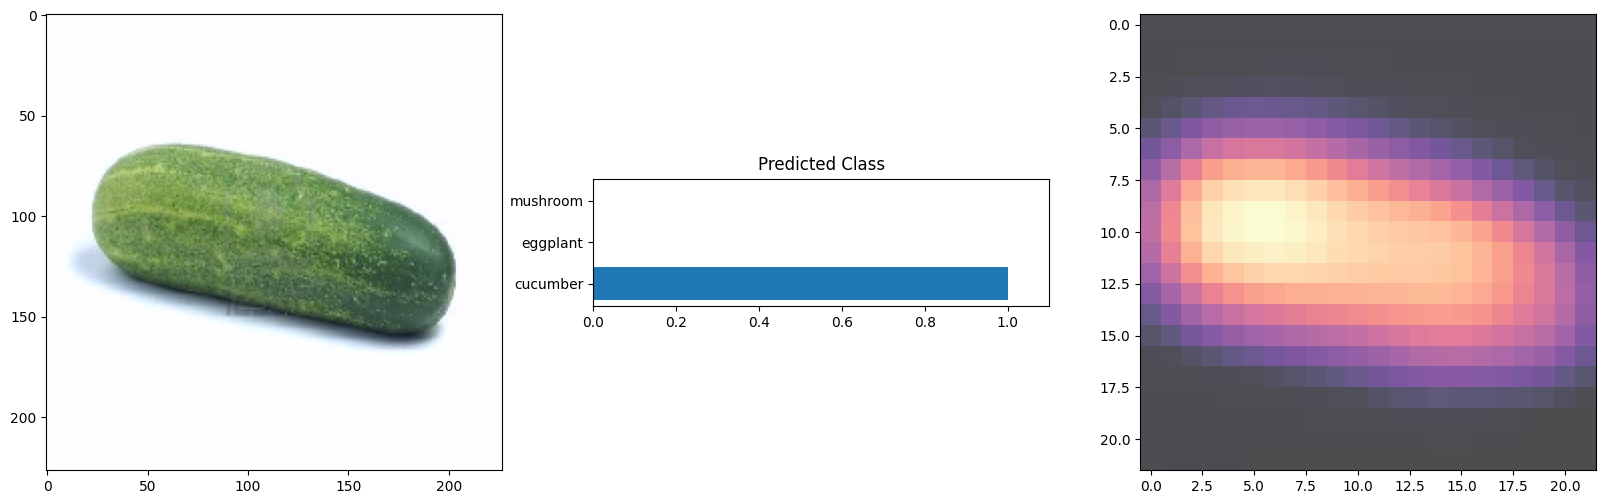

In [21]:
image, label = validset[7]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array ((0.485, 0.456, 0.486))

image = image.unsqueeze(0).to(DEVICE)

cucumber, eggplant, mushroom = 0, 1, 2

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][cucumber], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)